In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from config import *

CATEGORIES_REVERSE = {v: k for k, v in CATEGORIES_CODES.items()}

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

In [7]:
class DataLoader:
    __slots__ = ('images', '__index', 'labels', '_size', 'data')
    shape = (224, 224, 1)
    
    def __init__(self, *args) -> None:
        self.data = pd.concat([pd.read_csv(file) for file in args], ignore_index=True)
        self.__index, self._size = 0, self.data.shape[0]
        
        self.images = np.empty((self._size,) + self.shape, dtype='float16')
        self.labels = np.empty(self._size, dtype='uint8')

    def load_data(self) -> None:
        for _, _path, _categories in self.data.values:
            self.add_image(_path, _categories)

    def add_image(self, _path: str, category: int) -> None:
        image_path = f"data/train/{CATEGORIES_REVERSE[category]}/{_path}"
        img = ~cv2.imread(image_path, 0) / 255
        
        # img = img_as_float(cv2.imread(image_path, 0)) < 0.2
        # img = morphology.thin(img, max_num_iter=5)
        # img = morphology.binary_dilation(img, footprint=disk(1))

        self.images[self.__index] = np.asarray(img, dtype='float16').reshape(self.shape)
        self.labels[self.__index] = category
        self.__index += 1

        print(f"[+] Progress: {self.__index}/{self._size}", end='\r')
        
        if self.__index == self._size:
            self.labels = to_categorical(self.labels)
            print(f"\n[+] DONE {self._size}/{self._size}")
            
    def show_image(self, index: int) -> None:
        plt.imshow(self.images[index], cmap='gray')

[+] Progress: 15399/15399
[+] DONE 15399/15399


,Unnamed: 0,IMG,CODE
0,14603,cd68269b-5a76-4eef-b66e-be4c6c1680ed.jpg,19
1,12346,a4c682c3-371c-4682-9008-37dbef03f020.jpg,16
2,12501,dc13f24f-8ab7-4d6e-b380-e6bd248343d4.jpg,16
3,13207,e1fa69ca-b9cf-4295-95b9-8ad565f1c02e.jpg,17
4,5170,a2214eb7-6b55-4545-8475-20d4d40475d4.jpg,6
5,15244,c32cf25e-32c9-494b-845b-9f1a7d1171e3.jpg,20
6,6495,97ac3076-e505-4169-9b17-2994c12a03cb.jpg,8
7,9512,8f044a0e-8922-4abe-af5b-e66fec843d04.jpg,12
8,5913,bc8ae91f-c716-49a2-b61b-d7a7b52e3738.jpg,7
9,14551,ba3081e9-f323-4746-a55f-2b17b7c78bb8.jpg,19


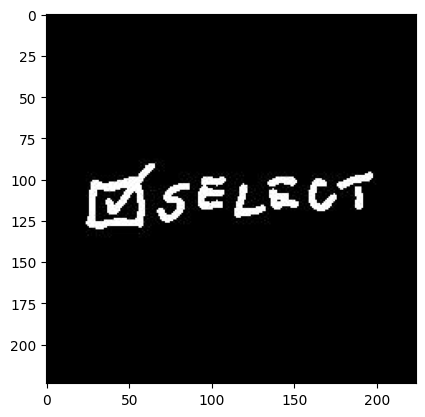

In [9]:
test_set_path = 'data/processed/test_set.csv'
train_set_path = 'data/processed/train_set.csv'

train_data = DataLoader(train_set_path, test_set_path)
train_data.load_data()
train_data.show_image(300)
train_data.data.head(10)

[+] Progress: 770/770
[+] DONE 770/770


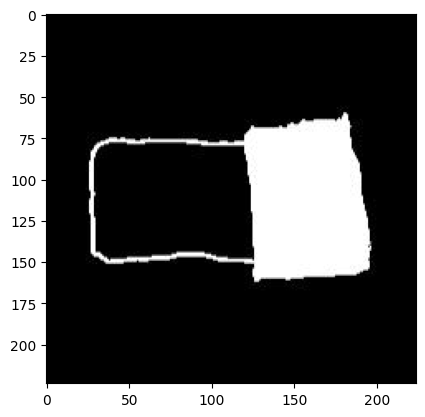

In [4]:
test_set_path = 'data/processed/test_set.csv'
test_data = DataLoader(test_set_path)
test_data.load_data()
test_data.show_image(3)

In [14]:
class SketchClassificatorModel:
    __slots__ = ('_data', '_shape', 'num_classes', 'model', 'version')
    
    def __init__(self, data, _version: str) -> None:
        self._data = data
        self._shape = data.shape
        self.num_classes = len(CATEGORIES_CODES)
        self.model = models.Sequential()
        self.version = _version

    def build_model(self) -> None:
        activation, final_activation = 'relu', 'softmax'
        kernel_size, pool_size = (6, 6), (4, 4)
        
        self.model.add(layers.Conv2D(32, kernel_size, activation=activation, input_shape=self._shape))
        self.model.add(layers.MaxPooling2D(pool_size=pool_size))
        self.model.add(layers.Conv2D(64, kernel_size=kernel_size, activation=activation))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.MaxPooling2D(pool_size=pool_size))
        self.model.add(layers.Conv2D(128, kernel_size=kernel_size, activation=activation))
        self.model.add(layers.GlobalAveragePooling2D())
        self.model.add(layers.Dense(128, activation=activation))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(self.num_classes, activation=final_activation))
        
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    def train(self) -> None:
        self.model.fit(self._data.images, self._data.labels, epochs=37, batch_size=64)
    
    def save(self) -> None:
        self.model.save(f'models/model_v{self.version}.h5')

In [17]:
sketch_model = SketchClassificatorModel(train_data, '0.2.5')
sketch_model.build_model()
sketch_model.train()
sketch_model.save()


del sketch_model

Epoch 1/40
241/241 [==============================] - 105s 430ms/step - loss: 2.4126 - accuracy: 0.2400
Epoch 2/40
241/241 [==============================] - 107s 444ms/step - loss: 1.6636 - accuracy: 0.4806
Epoch 3/40
241/241 [==============================] - 107s 446ms/step - loss: 1.3671 - accuracy: 0.5767
Epoch 4/40
241/241 [==============================] - 107s 446ms/step - loss: 1.2062 - accuracy: 0.6204
Epoch 5/40
241/241 [==============================] - 107s 445ms/step - loss: 1.0883 - accuracy: 0.6635
Epoch 6/40
241/241 [==============================] - 107s 445ms/step - loss: 1.0086 - accuracy: 0.6864
Epoch 7/40
241/241 [==============================] - 107s 444ms/step - loss: 0.9193 - accuracy: 0.7132
Epoch 8/40
241/241 [==============================] - 108s 449ms/step - loss: 0.8653 - accuracy: 0.7298
Epoch 9/40
241/241 [==============================] - 108s 449ms/step - loss: 0.8145 - accuracy: 0.7460
Epoch 10/40
241/241 [==============================] - 112s 464m

KeyboardInterrupt: 

In [5]:
for models in os.listdir('models'):
    model_test = load_model(f'models/{models}')
    print(f'Model version: {models[6:-3]}')
    test_loss, test_accuracy = model_test.evaluate(test_data.images, test_data.labels)

Model version: v0.1.1
25/25 [==============================] - 3s 117ms/step - loss: 1.2615 - accuracy: 0.7792
Model version: v0.1.10
25/25 [==============================] - 2s 64ms/step - loss: 0.8251 - accuracy: 0.7571
Model version: v0.1.11
25/25 [==============================] - 2s 65ms/step - loss: 0.7785 - accuracy: 0.7909
Model version: v0.1.12
25/25 [==============================] - 2s 64ms/step - loss: 0.7126 - accuracy: 0.8000
Model version: v0.1.13
25/25 [==============================] - 2s 64ms/step - loss: 0.1147 - accuracy: 0.9753
Model version: v0.1.14
25/25 [==============================] - 2s 63ms/step - loss: 0.1102 - accuracy: 0.9818
Model version: v0.1.15
25/25 [==============================] - 2s 63ms/step - loss: 0.1081 - accuracy: 0.9870
Model version: v0.1.16
25/25 [==============================] - 2s 66ms/step - loss: 0.7471 - accuracy: 0.8052
Model version: v0.1.17
25/25 [==============================] - 2s 64ms/step - loss: 0.7458 - accuracy: 0.8117
M

In [0]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(len(CATEGORIES_CODES), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data.images, train_data.labels, epochs=5, batch_size=64, validation_data=(test_data.images, test_data.labels))